In [73]:
%matplotlib inline

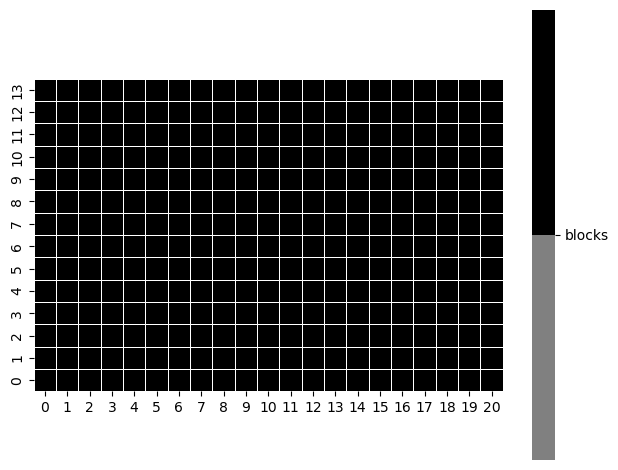

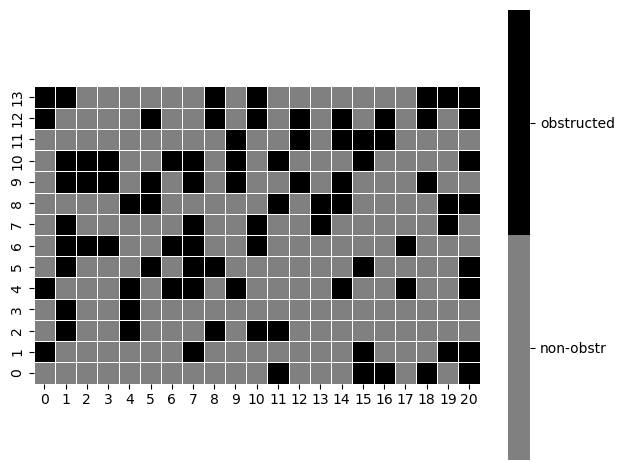

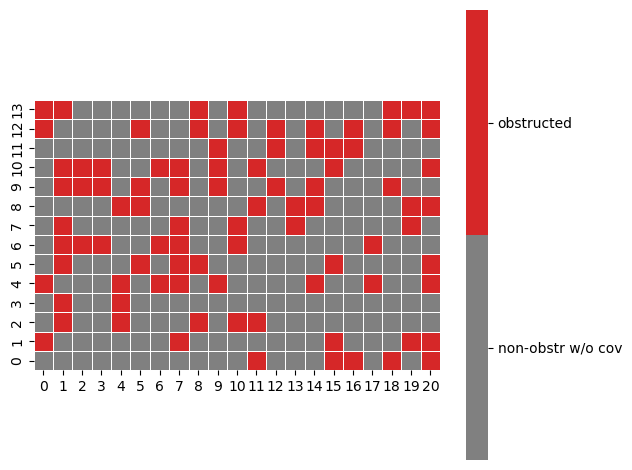

[[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1]
 [1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1]
 [0 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1]
 [0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1]
 [0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0]
 [0 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1]
 [0 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0]
 [0 1 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
 [1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1]]


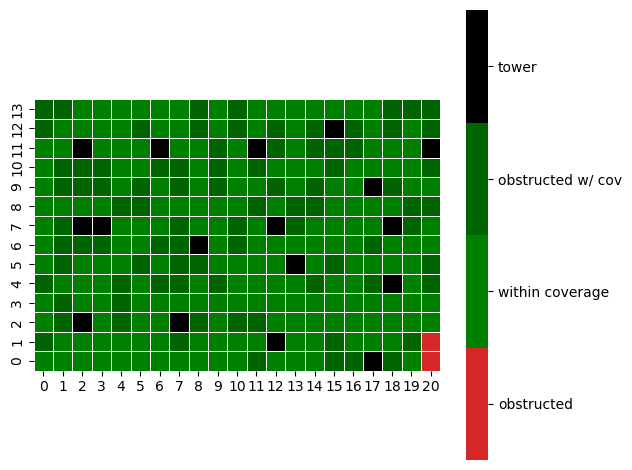

(3, 4)


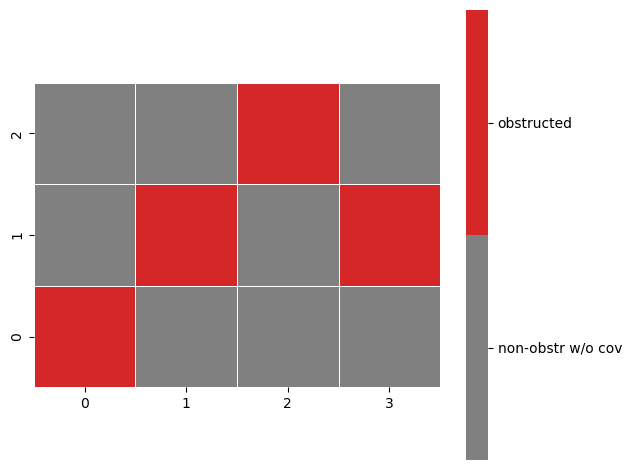

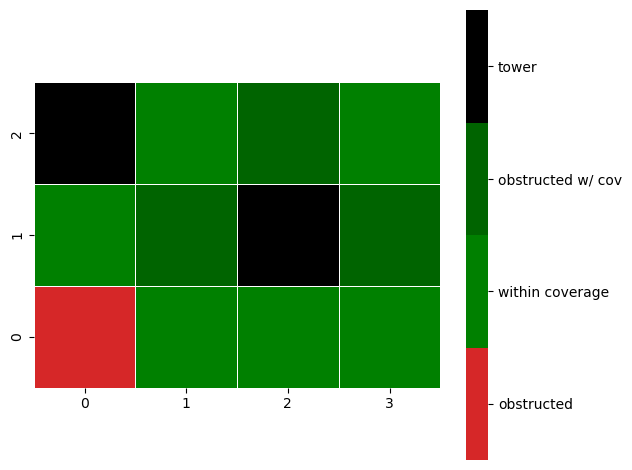

In [74]:
import math

from collections import deque
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors


class CityGrid:
    def __init__(self, n, m, obstruction_cov=0.3, seed=None):
        self.n = n
        self.m = m
        self.grid = np.zeros(
            (m, n), dtype=int
        )  # 0 represents unobstructed, 1 represents obstructed blocks
        self.rng = np.random.default_rng(seed)
        self.place_obstructions(obstruction_cov)
        self.orig_grid = self.grid.copy()
        self.towers = set()
        self.tower_graph = {}
        self.optimal_paths = {}

    def place_obstructions(self, coverage):
        # Calculate the number of needed obstructions to ensure strictly greater than the specified coverage
        n_obstructions = math.ceil(self.n * self.m * coverage)
        # Generate indices for obstructed blocks, ensuring no duplicate positions
        obstructed_idx = self.rng.choice(
            self.n * self.m, size=n_obstructions, replace=False
        )
        # Assign 1 (for obstructed blocks) to indices
        self.grid.reshape(-1)[obstructed_idx] = 1

    def place_tower(self, x, y, tower_range, display=False):
        # Check if the specified location is unobstructed
        if self.grid[y, x] == 0 or self.grid[y, x] == 2:
            # Place a tower with the given range
            # use max(0, idx) to prevent reversal
            temp = self.grid[
                max(0, y - tower_range) : y + tower_range + 1,
                max(0, x - tower_range) : x + tower_range + 1,
            ]
            self.grid[
                max(0, y - tower_range) : y + tower_range + 1,
                max(0, x - tower_range) : x + tower_range + 1,
            ] = np.where(
                temp < 2, temp + 2, temp
            )  # 2 and 3 represent tower coverage for non-obstructed and obstructed blocks respectively
            # Place the tower with value 4
            self.grid[y, x] = 4
            # self.towers.add((y, x))
            self.towers.add((x, y))
            # Plot coverage of placed tower if specified
            if display:
                temp_grid = self.orig_grid.copy()
                temp_grid[
                    max(0, y - tower_range) : y + tower_range + 1,
                    max(0, x - tower_range) : x + tower_range + 1,
                ] += 2
                self.visualize_grid(temp_grid)
        else:
            print("Tower placement is obstructed.")

    def _generate_sets(self, tower_range):
        # Generate a list of sets that contain coordinates for all possible towers that can cover an empty block
        sets_of_towers = []
        # Iterate through all possible empty blocks
        for row in range(0, self.grid.shape[0]):
            for col in range(0, self.grid.shape[1]):
                if self.grid[row, col] != 0:
                    continue
                covering_towers = set()
                # Iterate through possible tower placements to cover the block
                for range_row in range(
                    max(0, row - tower_range),
                    min(self.grid.shape[0], row + tower_range + 1),
                ):
                    for range_col in range(
                        max(0, col - tower_range),
                        min(self.grid.shape[1], col + tower_range + 1),
                    ):
                        if self.grid[range_row, range_col] != 0:
                            continue
                        # Add towers to set
                        covering_towers.add((range_col, range_row))
                # Add sets to list
                sets_of_towers.append(covering_towers)
        return sets_of_towers

    def optimize_tower_placement(self, tower_range):
        def _most_frequent(list_of_sets):
            # Return the most frequent tower coordinates
            return max(set(list_of_sets), key=list_of_sets.count)

        set_list = self._generate_sets(tower_range)

        # return_set = []
        # Repeat until all empty blocks are covered
        while set_list:
            # Store all towers of sets into a list
            towers = []
            for s in set_list:
                for el in s:
                    towers.append(el)
            # Obtain the most frequent one
            tower = _most_frequent(towers)
            # return_set.append(element)
            # Place the most frequent tower
            self.place_tower(*tower, tower_range)

            # Remove sets containing the placed tower from the list
            new_set_list = []
            for s in set_list:
                if tower not in s:
                    new_set_list.append(s)
            set_list = new_set_list

        # print(len(return_set))

    def _plot_path(self, path):
        # Create a list of x, y values for a given path
        x = []
        y = []
        for x_point, y_point in self.optimal_paths[frozenset(path)]:
            x.append(x_point + 0.5)
            y.append(y_point + 0.5)
        # Set visible color cycle
        current_clrs = list(mcolors.TABLEAU_COLORS.keys())
        plt.rcParams["axes.prop_cycle"] = plt.cycler(
            color=current_clrs[1:2] + current_clrs[3:]
        )
        plt.plot(x, y, linewidth=4, alpha=0.9)

    def visualize_grid(self, paths=False):
        nu = np.unique(self.grid)
        # Define custom colormap
        all_col = ["grey", "tab:red", "green", "darkgreen", "black"]
        colors = all_col[nu[0] : nu[-1] + 1]
        cmap = ListedColormap(colors)
        # Plot heatmap
        ax = sns.heatmap(self.grid, cmap=cmap, cbar=True, linewidths=0.5, square=True)
        ax.invert_yaxis()
        # Specify colorbar labelling after it's been generated
        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks(np.linspace(nu[0], nu[-1], len(nu) * 2 + 1)[1::2])
        colorbar.set_ticklabels(
            [
                "non-obstr w/o cov",
                "obstructed",
                "within coverage",
                "obstructed w/ cov",
                "tower",
            ][nu[0] : nu[-1] + 1]
        )

        # Plot paths
        if paths == "all" and self.optimal_paths:
            for path in self.optimal_paths:
                self._plot_path(path)
        elif paths and frozenset(paths) in self.optimal_paths:
            self._plot_path(paths)

        plt.tight_layout()
        plt.show()

    def visualize_obstructions(self):
        # Filter to only show obstructions
        obstructions = np.where((self.grid == 1) | (self.grid == 3), 1, 0)
        nu = np.unique(obstructions)
        # Define custom colormap
        cmap = ListedColormap(["grey", "black"])
        # Plot heatmap
        ax = sns.heatmap(
            obstructions, cmap=cmap, cbar=True, linewidths=0.5, square=True
        )
        ax.invert_yaxis()
        # Specify colorbar labelling after it's been generated
        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks(np.linspace(nu[0], nu[-1], len(nu) * 2 + 1)[1::2])
        colorbar.set_ticklabels(["non-obstr", "obstructed"][nu[0] : nu[-1] + 1])

        plt.tight_layout()
        plt.show()

    def visualize_towers(self):
        # Filter to only show towers
        towers = np.where(self.grid == 4, 1, 0)
        nu = np.unique(towers)
        # Define custom colormap
        cmap = ListedColormap(["grey", "black"])
        # Plot heatmap
        ax = sns.heatmap(towers, cmap=cmap, cbar=True, linewidths=0.5, square=True)
        ax.invert_yaxis()
        # Specify colorbar labelling after it's been generated
        colorbar = ax.collections[0].colorbar
        colorbar.set_ticks(np.linspace(nu[0], nu[-1], len(nu) * 2 + 1)[1::2])
        colorbar.set_ticklabels(["blocks", "towers"][nu[0] : nu[-1] + 1])

        plt.tight_layout()
        plt.show()

    def _generate_tower_graph(self, tower_range, grid):
        # Iterate through all placed towers
        for tower in self.towers:
            self.tower_graph[tower] = []
            # Iterate through all blocks within range
            for range_row in range(
                max(0, tower[1] - tower_range),
                min(grid.shape[0], tower[1] + tower_range + 1),
            ):
                for range_col in range(
                    max(0, tower[0] - tower_range),
                    min(grid.shape[1], tower[0] + tower_range + 1),
                ):
                    # Add blocks with towers in range to list
                    if grid[range_row, range_col] == 4 and (tower[0], tower[1]) != (
                        range_col,
                        range_row,
                    ):
                        self.tower_graph[tower].append((range_col, range_row))
            print()
        print(f"{self.tower_graph=}")
        print("done")

    def most_reliable_path(
        self, start_tower, end_tower, tower_range, recalculate=False
    ):
        # Create a graph representation of towers and their connections
        if not self.tower_graph or recalculate:
            self._generate_tower_graph(tower_range, self.grid)

        # Perform BFS to find the shortest path and store the shortest path for all paths that start (or end) with the start_tower
        if frozenset([start_tower, end_tower]) not in self.optimal_paths or recalculate:
            visited = set([start_tower])
            queue = deque(
                [(start_tower, [start_tower])]
            )  # double-ended queue containing the node and the path between towers

            while queue:
                current_node, path = queue.popleft()
                # Iterate over neighboring towers of current node
                for n in self.tower_graph[current_node]:
                    if n not in visited:
                        visited.add(n)
                        queue.append([n, path + [n]])
                        # Add intermediate steps for future access
                        if frozenset([n, start_tower]) not in self.optimal_paths:
                            self.optimal_paths[frozenset([n, start_tower])] = path + [n]
                        print(f"{visited=}")
                        print(f"{queue=}")
                        print()

        if frozenset([start_tower, end_tower]) in self.optimal_paths:
            print(
                f"Most reliable path: {self.optimal_paths[frozenset([start_tower, end_tower])]}"
            )
        else:
            print("No path found.")


my_city = CityGrid(21, 7 * 2, seed=42)
# my_city.place_tower(3, 3, 3)
# my_city.place_tower(10, 3, 3)
# my_city.place_tower(15, 3, 3)
my_city.visualize_towers()
my_city.visualize_obstructions()
my_city.visualize_grid()
print(my_city.grid)
my_city.optimize_tower_placement(2)
my_city.visualize_grid()

tempc = CityGrid(4, 3, seed=42)
print(tempc.grid.shape)
tempc.visualize_grid()
tempc.optimize_tower_placement(1)
tempc.visualize_grid()

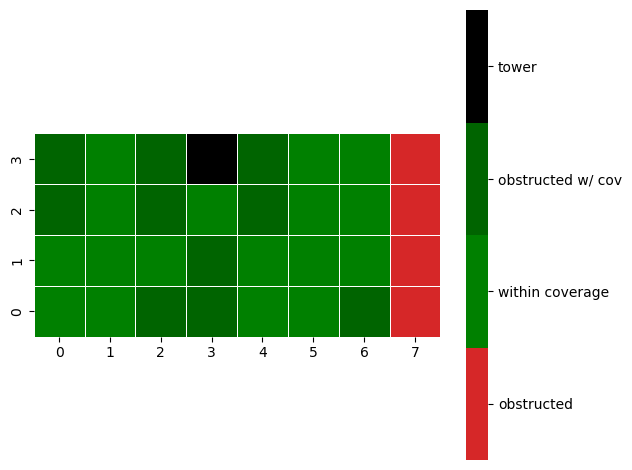

In [75]:
my_city = CityGrid(8, 4, seed=42)
my_city.place_tower(3, 3, 3)
my_city.grid[:, -1] = 1
my_city.visualize_grid()

In [ ]:
my_city = CityGrid(8, 4, seed=42)
my_city.place_tower(3, 3, 3)
my_city.grid[:, -1] = 0
my_city.visualize_grid()

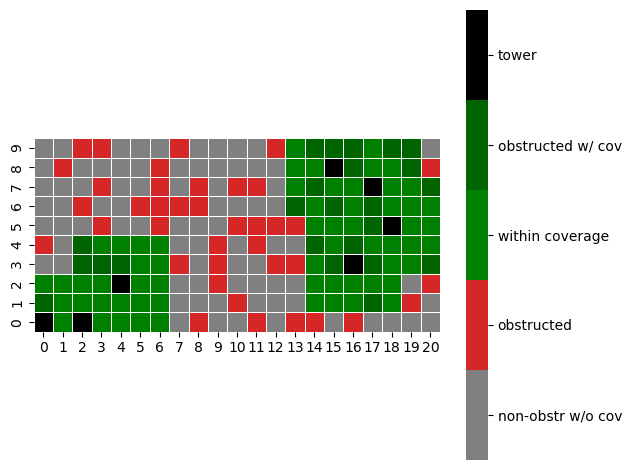

array([[4, 2, 4, 2, 2, 2, 2, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0],
       [3, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 3, 2, 1, 0],
       [2, 2, 2, 2, 4, 2, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 1],
       [0, 0, 3, 3, 3, 2, 2, 1, 0, 1, 0, 0, 1, 1, 2, 3, 4, 3, 2, 2, 3],
       [1, 0, 3, 2, 2, 2, 2, 0, 0, 1, 0, 1, 0, 0, 3, 2, 3, 2, 2, 2, 2],
       [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 4, 2, 2],
       [0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 3, 2, 3, 2, 3, 2, 2, 2],
       [0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 2, 3, 2, 2, 4, 2, 2, 3],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 4, 3, 2, 2, 3, 1],
       [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 3, 3, 3, 2, 3, 3, 0]])

In [77]:
city = CityGrid(21, 10, seed=42)
city.place_tower(0, 0, 2)
city.place_tower(2, 0, 2)
city.place_tower(4, 2, 2)
city.place_tower(15, 8, 2)
city.place_tower(17, 7, 2)
city.place_tower(18, 5, 2)
city.place_tower(16, 3, 2)
city.visualize_grid()
city.grid

In [78]:
city.most_reliable_path((4, 2), (0, 0), 2)
city.most_reliable_path((15, 8), (16, 3), 2)









self.tower_graph={(17, 7): [(18, 5), (15, 8)], (15, 8): [(17, 7)], (0, 0): [(2, 0)], (16, 3): [(18, 5)], (2, 0): [(0, 0), (4, 2)], (4, 2): [(2, 0)], (18, 5): [(16, 3), (17, 7)]}
done
visited={(2, 0), (4, 2)}
queue=deque([[(2, 0), [(4, 2), (2, 0)]]])

visited={(2, 0), (4, 2), (0, 0)}
queue=deque([[(0, 0), [(4, 2), (2, 0), (0, 0)]]])

Most reliable path: [(4, 2), (2, 0), (0, 0)]
visited={(17, 7), (15, 8)}
queue=deque([[(17, 7), [(15, 8), (17, 7)]]])

visited={(18, 5), (17, 7), (15, 8)}
queue=deque([[(18, 5), [(15, 8), (17, 7), (18, 5)]]])

visited={(16, 3), (18, 5), (17, 7), (15, 8)}
queue=deque([[(16, 3), [(15, 8), (17, 7), (18, 5), (16, 3)]]])

Most reliable path: [(15, 8), (17, 7), (18, 5), (16, 3)]


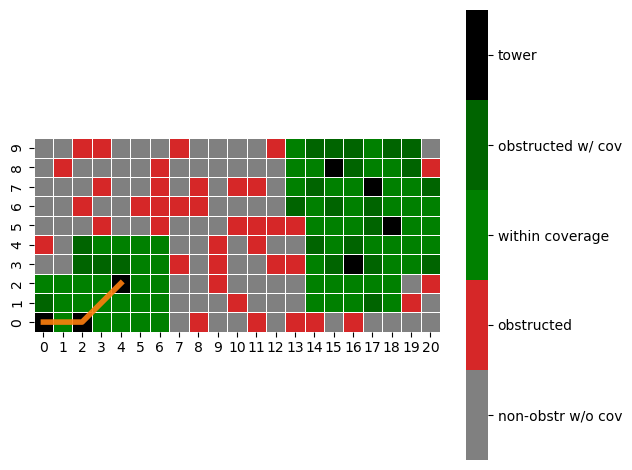

In [79]:
city.visualize_grid(paths=((4, 2), (0, 0)))

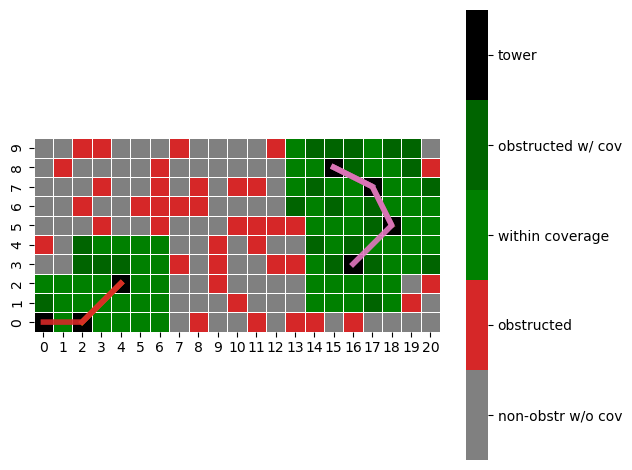

In [80]:
city.visualize_grid(paths='all')

In [81]:
city.optimal_paths

{frozenset({(2, 0), (4, 2)}): [(4, 2), (2, 0)],
 frozenset({(0, 0), (4, 2)}): [(4, 2), (2, 0), (0, 0)],
 frozenset({(15, 8), (17, 7)}): [(15, 8), (17, 7)],
 frozenset({(15, 8), (18, 5)}): [(15, 8), (17, 7), (18, 5)],
 frozenset({(15, 8), (16, 3)}): [(15, 8), (17, 7), (18, 5), (16, 3)]}